In [151]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from sklearn.model_selection import train_test_split

import tqdm

import warnings

In [4]:
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

In [5]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [6]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Data Loading

In [98]:
trx_df = read_txn_data(use_load=False)
trx_df = preprocess_txn_data(trx_df, freq='1min')
trx_df['log_deseasoned_total_volume'] = np.log(trx_df['deseasoned_total_volume'] + 1e-07)

lob_df = create_lob_dataset(use_load=False)

df_merged = merge_txn_and_lob(trx_df, lob_df)
df_merged.head()

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
5819,2018-06-04 22:00:05+00:00,0.059804,0.730357,5.0,10.0,0.670553,5.0,0.790162,4.380444,0.180384,-1.712667,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
5820,2018-06-04 22:01:05+00:00,0.089359,0.849477,3.0,4.0,0.760118,1.0,0.938836,3.692009,0.254289,-1.369285,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
5821,2018-06-04 22:02:05+00:00,0.313458,0.508952,2.0,4.0,0.195494,2.0,0.822410,3.324900,0.247349,-1.396955,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462
5822,2018-06-04 22:03:05+00:00,0.000992,0.199219,1.0,4.0,0.198227,3.0,0.200211,4.128645,0.048493,-3.026331,2650.599402,586308.612876,1718.061157,2650.599402,2650.599402,3.631836,51.036074,160.641345,4.32,583658.013474,1714.429321,2599.563327,2489.958056
5823,2018-06-04 22:04:05+00:00,0.172042,0.000000,7.0,0.0,0.172042,7.0,0.172042,6.271124,0.027434,-3.595966,2650.082079,586314.173248,1715.979046,2650.082079,2650.082079,3.704804,51.092926,160.489197,4.32,583664.091169,1712.274243,2598.989153,2489.592882


In [1]:
train_size = int(0.7 * trx_df.shape[0])
trx_df_train, trx_df_test = trx_df.iloc[:train_size], trx_df.iloc[train_size:]

# trx_df_train['time'] = trx_df_train['datetime'].dt.time
# Step 2: Extract time of day (minute-level resolution)
trx_df_train['time_of_day'] = trx_df_train['datetime'].dt.strftime('%H:%M')
trx_df_test['time_of_day'] = trx_df_test['datetime'].dt.strftime('%H:%M')

# Step 3: Compute mean volume per time_of_day from training data
mean_volume_per_minute = trx_df_train.groupby('time_of_day')['total_volume'].mean().to_dict()

# Step 4: Map mean volume to train and test
trx_df_train['mean_volume'] = trx_df_train['time_of_day'].map(mean_volume_per_minute)
trx_df_test['mean_volume'] = trx_df_test['time_of_day'].map(mean_volume_per_minute)

trx_df_train['deseasoned_total_volume'] = trx_df_train['total_volume'] / trx_df_train['mean_volume']
trx_df_test['deseasoned_total_volume'] = trx_df_test['total_volume'] / trx_df_test['mean_volume']

trx_df_train['log_deseasoned_total_volume'] = np.log(trx_df_train['deseasoned_total_volume'] + 1e-7)
trx_df_test['log_deseasoned_total_volume'] = np.log(trx_df_test['deseasoned_total_volume'] + 1e-7)

trx_df_train.drop(['time_of_day'], axis=1, inplace=True)
trx_df_test.drop(['time_of_day'], axis=1, inplace=True)

NameError: name 'trx_df' is not defined

In [100]:
trx_df_train.loc[5819:5823]

,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume
5819,2018-06-04 22:00:05+00:00,0.059804,0.730357,5.0,10.0,0.670553,5.0,0.790162,4.159836,0.189950,-1.660993
5820,2018-06-04 22:01:05+00:00,0.089359,0.849477,3.0,4.0,0.760118,1.0,0.938836,4.120465,0.227847,-1.479080
5821,2018-06-04 22:02:05+00:00,0.313458,0.508952,2.0,4.0,0.195494,2.0,0.822410,3.618109,0.227304,-1.481467
5822,2018-06-04 22:03:05+00:00,0.000992,0.199219,1.0,4.0,0.198227,3.0,0.200211,4.720850,0.042410,-3.160370
5823,2018-06-04 22:04:05+00:00,0.172042,0.000000,7.0,0.0,0.172042,7.0,0.172042,6.621891,0.025981,-3.650392


### ARMA-GARCH

In [5]:
# start = time.time()
# best_model = pmdarima.auto_arima(train_data['Price'],                                    
#                                  seasonal=False, stationary=False, 
#                                  m=7, information_criterion='aic', 
#                                  max_order=20,                                     
#                                  max_p=10, max_d=2, max_q=10,                                     
#                                  max_P=10, max_D=2, max_Q=10,                                   
#                                  error_action='ignore')
# print("best model --> (p, d, q):", best_model.order)
# elapsed_time = time.time() - start
# print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

In [ ]:
# Ensure the column is a series and drop missing values

## Runs 4 hours

# series = trx_df['log_deseasoned_total_volume'].dropna()

# # Split data into 80% train, 20% test
# train_size = int(0.8 * len(series))
# train, test = series[:train_size], series[train_size:]

# # Step 1: Search for the best (p, q) based on AIC
# def find_best_arma(train_series, p_range=(0, 5), q_range=(0, 5)):
#     best_aic = np.inf
#     best_order = None
#     aic_dict = {}
#     for p, q in tqdm.tqdm(product(range(p_range[0], p_range[1] + 1), range(q_range[0], q_range[1] + 1)), total=len(range(p_range[0], p_range[1] + 1)) * len(range(q_range[0], q_range[1] + 1))):
#         if p == 0 and q == 0:
#             continue  # Skip ARMA(0,0)
#         try:
#             model = ARIMA(train_series, order=(p, 0, q))
#             result = model.fit()
#             aic_dict[(p, q)] = result.aic
#             if result.aic < best_aic:
#                 best_aic = result.aic
#                 best_order = (p, q)
#         except:
#             continue  # Skip models that fail to converge
#     return aic_dict, best_order

# aic_dict, best_order = find_best_arma(train, (0, 8), (0, 8))
# best_p, best_q = best_order
# print(f"Optimal ARMA order: ({best_p}, {best_q})")



 21%|██        | 17/81 [10:43<1:29:34, 83.98s/it]c:\Users\aliak\my_space\ETH\ML Complex Systems\MLFCS\ML_fin_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 26%|██▌       | 21/81 [19:07<1:55:05, 115.09s/it]c:\Users\aliak\my_space\ETH\ML Complex Systems\MLFCS\ML_fin_project\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 27%|██▋       | 22/81 [23:17<2:32:47, 155.37s/it]c:\Users\aliak\my_space\ETH\ML Complex Systems\MLFCS\ML_fin_project\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 35%|███▍      | 28/8

Optimal ARMA order: (6, 7)


In [ ]:
train, test = trx_df_train['log_deseasoned_total_volume'], trx_df_test['log_deseasoned_total_volume']

best_p, best_q = 6, 7

# Step 2: Fit ARMA-GARCH(1,1) model on train set
arma_model = ARIMA(train, order=(best_p, 0, best_q)).fit(method_kwargs={"solver": "lbfgs", "maxiter": 500})
residuals = arma_model.resid  # Get ARMA residuals

In [102]:
print(arma_model.summary())

                                    SARIMAX Results                                    
Dep. Variable:     log_deseasoned_total_volume   No. Observations:               140592
Model:                          ARIMA(6, 0, 7)   Log Likelihood             -331758.036
Date:                         Sun, 20 Apr 2025   AIC                         663546.072
Time:                                 15:49:29   BIC                         663693.876
Sample:                                      0   HQIC                        663590.251
                                      - 140592                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9048      0.211     -9.032      0.000      -2.318      -1.491
ar.L1         -0.8348      0.114     -7.302      0.000     

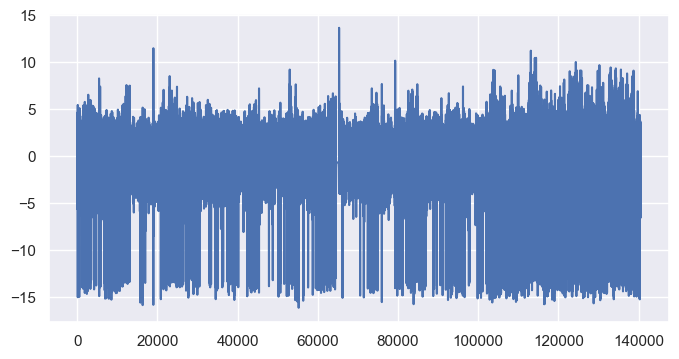

In [103]:
plt.plot(residuals)

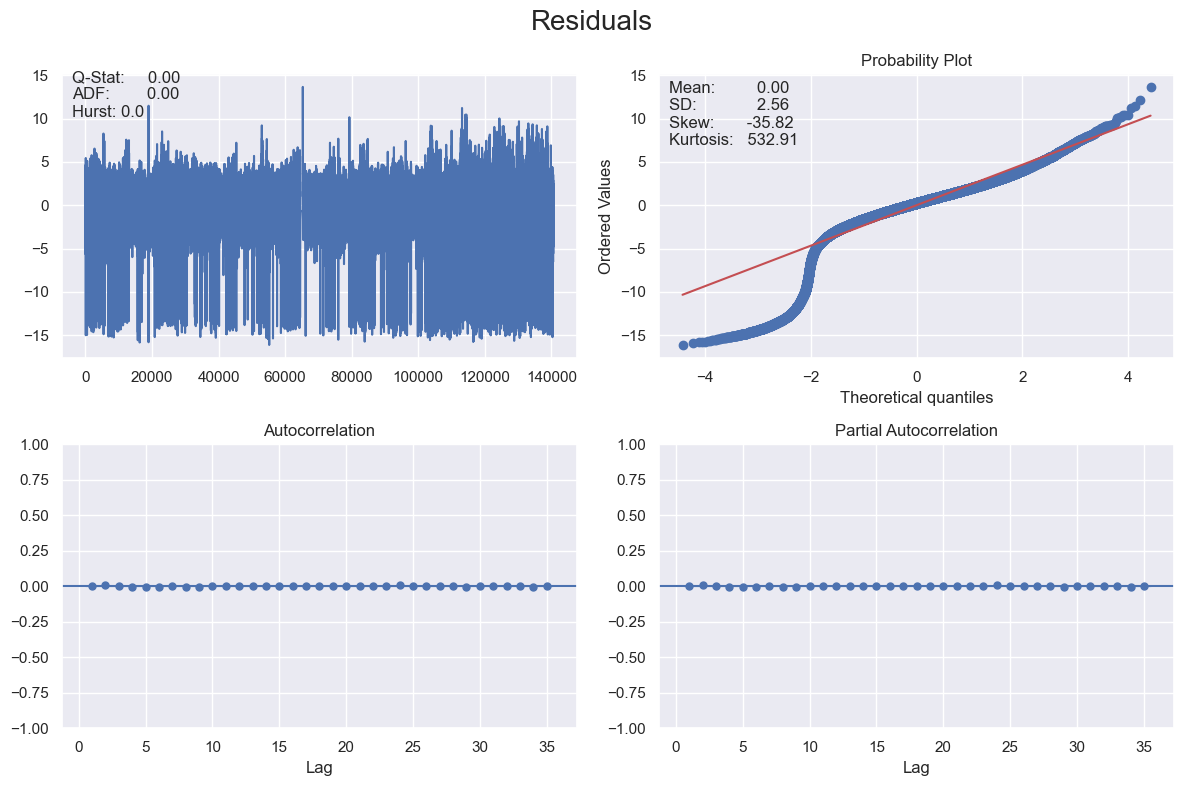

In [104]:
# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(residuals, lags=35, title='Residuals')

In [107]:
garch_model = arch_model(residuals, vol="Garch", p=1, q=1, mean="zero")
garch_result = garch_model.fit(options={"maxiter": 500})#disp="off", 


Iteration:      1,   Func. Count:      5,   Neg. LLF: 21116113.339682892
Iteration:      2,   Func. Count:     12,   Neg. LLF: 311507.0015397022
Iteration:      3,   Func. Count:     17,   Neg. LLF: 309952.8888596189
Iteration:      4,   Func. Count:     21,   Neg. LLF: 486409.06223665836
Iteration:      5,   Func. Count:     26,   Neg. LLF: 396296.37576497544
Iteration:      6,   Func. Count:     33,   Neg. LLF: 340838.027747595
Iteration:      7,   Func. Count:     38,   Neg. LLF: 309554.53971721523
Iteration:      8,   Func. Count:     43,   Neg. LLF: 337194.96600458154
Iteration:      9,   Func. Count:     48,   Neg. LLF: 309726.10953768983
Iteration:     10,   Func. Count:     53,   Neg. LLF: 309293.7530101161
Iteration:     11,   Func. Count:     58,   Neg. LLF: 309314.05129371834
Iteration:     12,   Func. Count:     63,   Neg. LLF: 309279.1941658376
Iteration:     13,   Func. Count:     67,   Neg. LLF: 309279.193290091
Iteration:     14,   Func. Count:     71,   Neg. LLF: 30927

In [108]:
print(garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -309279.
Distribution:                  Normal   AIC:                           618564.
Method:            Maximum Likelihood   BIC:                           618594.
                                        No. Observations:               140592
Date:                Sun, Apr 20 2025   Df Residuals:                   140592
Time:                        15:52:15   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0112  2.022e-03      5.535  3.114e-08 [7.

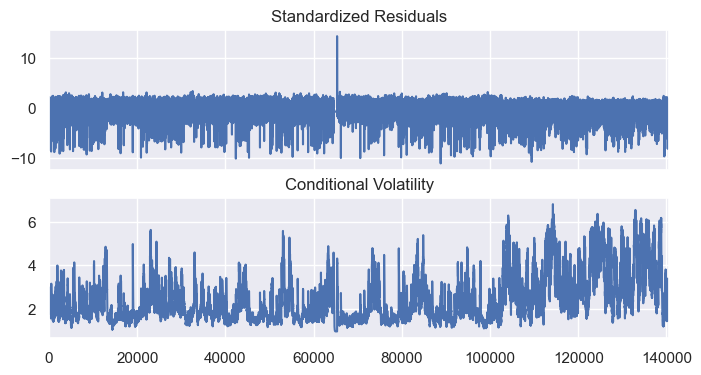

In [109]:
# Plot fitted results
garch_result.plot()
plt.show()

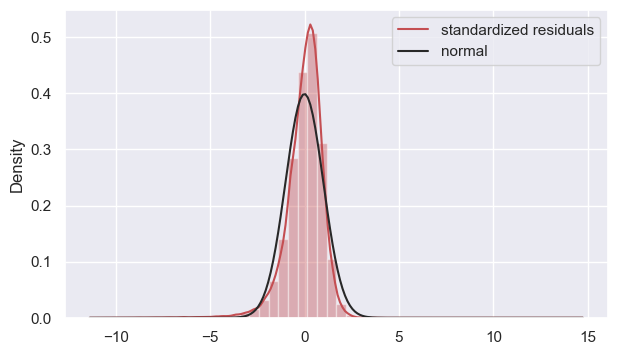

In [110]:
# Obtain model estimated residuals and volatility
gm_resid = garch_result.resid
gm_std = garch_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('standardized residuals', 'normal'))
plt.show()

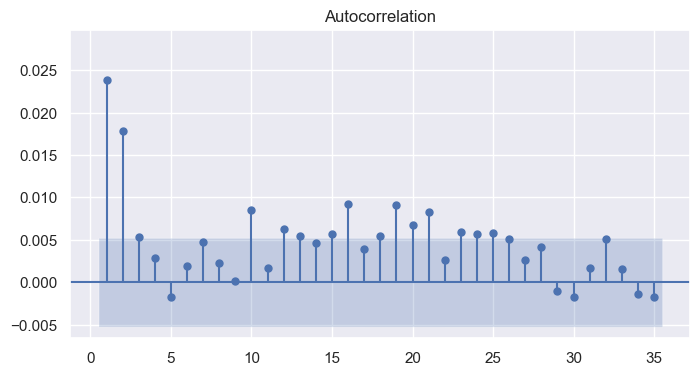

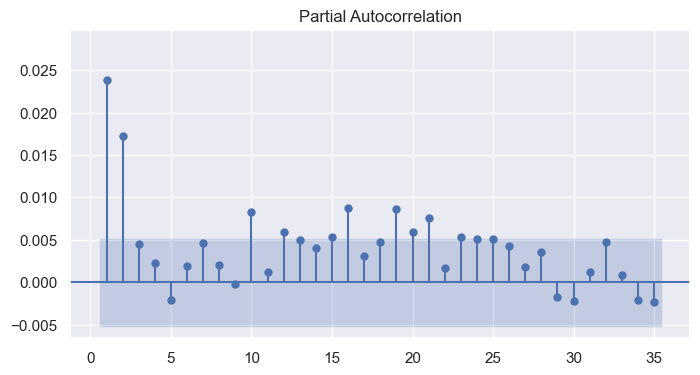

In [111]:
plot_acf(gm_std_resid, lags=35, zero=False, auto_ylims=True);
plot_pacf(gm_std_resid, lags=35, zero=False, auto_ylims=True);

In [17]:
# Step 3: Forecast using ARMA-GARCH
forecast_horizon = len(test)
arma_forecast = arma_model.forecast(steps=forecast_horizon)
garch_forecast = garch_result.forecast(horizon=forecast_horizon)

# Extract variance predictions (volatility forecasts)
predicted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])  # Last row, all forecast steps

# Combine ARMA mean predictions with GARCH variance predictions
predictions = pd.DataFrame({
    "ARMA_Mean": arma_forecast.values,
    "GARCH_Volatility": predicted_volatility
}, index=test.index)

print(predictions.head())

        ARMA_Mean  GARCH_Volatility
140592  -0.406920          1.748324
140593  -0.323503          1.750559
140594  -0.365253          1.752789
140595  -0.362117          1.755013
140596  -0.350230          1.757232


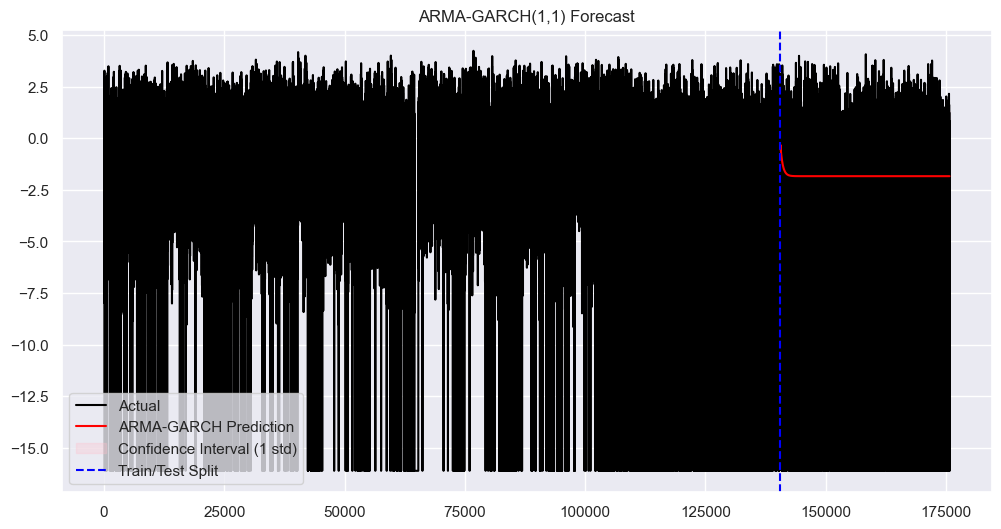

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label="Actual", color="black")
plt.plot(test.index, predictions["ARMA_Mean"], label="ARMA-GARCH Prediction", color="red")
plt.fill_between(test.index, 
                 predictions["ARMA_Mean"] - predictions["GARCH_Volatility"],
                 predictions["ARMA_Mean"] + predictions["GARCH_Volatility"], 
                 color='pink', alpha=0.3, label="Confidence Interval (1 std)")
plt.axvline(x=series.index[train_size], color="blue", linestyle="--", label="Train/Test Split")
plt.legend()
plt.title("ARMA-GARCH(1,1) Forecast")
plt.show()


### Prediction

In [112]:
print(garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -309279.
Distribution:                  Normal   AIC:                           618564.
Method:            Maximum Likelihood   BIC:                           618594.
                                        No. Observations:               140592
Date:                Sun, Apr 20 2025   Df Residuals:                   140592
Time:                        15:52:15   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0112  2.022e-03      5.535  3.114e-08 [7.

In [113]:
print(arma_model.summary())

                                    SARIMAX Results                                    
Dep. Variable:     log_deseasoned_total_volume   No. Observations:               140592
Model:                          ARIMA(6, 0, 7)   Log Likelihood             -331758.036
Date:                         Sun, 20 Apr 2025   AIC                         663546.072
Time:                                 15:52:59   BIC                         663693.876
Sample:                                      0   HQIC                        663590.251
                                      - 140592                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9048      0.211     -9.032      0.000      -2.318      -1.491
ar.L1         -0.8348      0.114     -7.302      0.000     

In [114]:
for index, value in zip(arma_model.params.index, arma_model.params):
    print(index, value)

const -1.9047668590885263
ar.L1 -0.834790165817636
ar.L2 0.7104641716432691
ar.L3 1.5642345620705593
ar.L4 0.88459460786704
ar.L5 -0.5866339614012573
ar.L6 -0.7407520086907179
ma.L1 1.0308775175056437
ma.L2 -0.4232802095183023
ma.L3 -1.4923807058013958
ma.L4 -1.093135769913235
ma.L5 0.3173967011824852
ma.L6 0.6716418192457424
ma.L7 0.05044733560620768
sigma2 6.563473716780876


In [115]:
garch_result.params

omega       0.011190
alpha[1]    0.022630
beta[1]     0.976244
Name: params, dtype: float64

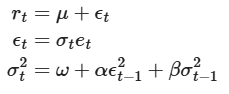

In [148]:
def construct_1step_ARMA_pred(returns, resids, coefs):
    ar_part = 0
    ma_part = 0

    for index, coef in zip(coefs.index, coefs):
        if 'ma.L' in index:
            lag = int(index.split('ma.L')[-1])
            ma_part += resids[-lag]*coef
        
        elif 'ar.L' in index:
            lag = int(index.split('ar.L')[-1])
            ar_part += returns[-lag]*coef

    return coefs['const'] + ma_part + ar_part

def construct_1step_GARCH_pred(resid, volatility, coefs):
    return np.sqrt(coefs["omega"] + coefs["alpha[1]"]*np.square(resid) + coefs["beta[1]"]*np.square(volatility))


returns_lagged = list(arma_model.fittedvalues[-6:].values)
resids_lagged = list(arma_model.resid[-7:].values)

resid_last, volat_last = garch_result.resid.values[-1], garch_result.conditional_volatility.values[-1]

preds = []
volatility_preds = []
resids = []

for test_value in tqdm.tqdm(test.values):
    pred = construct_1step_ARMA_pred(returns_lagged, resids_lagged, arma_model.params)
    preds.append(pred)
    returns_lagged = returns_lagged[1:] + [test_value]
    resids_lagged = resids_lagged[1:] + [test_value - pred]

    vol_pred = construct_1step_GARCH_pred(resid_last, volat_last, garch_result.params)
    volatility_preds.append(vol_pred)

    resid_last = test_value - pred
    resids.append(resid_last)
    volat_last = vol_pred

  0%|          | 0/35148 [00:00<?, ?it/s]

100%|██████████| 35148/35148 [00:08<00:00, 4055.58it/s]


In [149]:
trx_df_train['log_deseasonalized_preds'] = list(arma_model.fittedvalues)
trx_df_train['deseasonalized_preds'] = np.exp(trx_df_train['log_deseasonalized_preds'])
trx_df_train['preds'] = trx_df_train['deseasonalized_preds'] * trx_df_train['mean_volume']

trx_df_train['predicted_volatility'] = list(garch_result.conditional_volatility)
trx_df_train['resids_'] = list(garch_result.resid)


trx_df_test['log_deseasonalized_preds'] = preds
trx_df_test['deseasonalized_preds'] = np.exp(trx_df_test['log_deseasonalized_preds'])
trx_df_test['preds'] = trx_df_test['deseasonalized_preds'] * trx_df_test['mean_volume']

trx_df_test['predicted_volatility'] = volatility_preds
trx_df_test['resids_'] = resids


In [150]:
trx_df_test.tail()

,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,log_deseasonalized_preds,deseasonalized_preds,preds,predicted_volatility,resids_
175735,2018-09-30 21:56:05+00:00,1.310116,0.000000,21.0,0.0,1.310116,21.0,1.310116,5.693942,0.230089,-1.469287,-34.628240,9.144220e-16,5.206666e-15,30.142979,33.158953
175736,2018-09-30 21:57:05+00:00,0.134624,0.038058,2.0,1.0,0.096565,1.0,0.172682,4.857189,0.035552,-3.336761,-34.135857,1.496186e-15,7.267261e-15,30.197815,30.799096
175737,2018-09-30 21:58:05+00:00,1.491747,0.038143,10.0,1.0,1.453603,9.0,1.529890,7.595483,0.201421,-1.602357,-34.163303,1.455680e-15,1.105659e-14,30.194745,32.560946
175738,2018-09-30 21:59:05+00:00,0.010576,0.924569,1.0,8.0,0.913993,7.0,0.935145,6.195801,0.150932,-1.890925,-33.930453,1.837349e-15,1.138385e-14,30.233555,32.039528
175739,2018-09-30 22:00:05+00:00,0.983765,0.000000,9.0,0.0,0.983765,9.0,0.983765,4.159836,0.236491,-1.441843,-33.964472,1.775895e-15,7.387433e-15,30.258802,32.522628


In [136]:
trx_df_test[140600:140600+15]

,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,log_deseasonalized_preds,deseasonalized_preds,preds,predicted_volatility,resids_


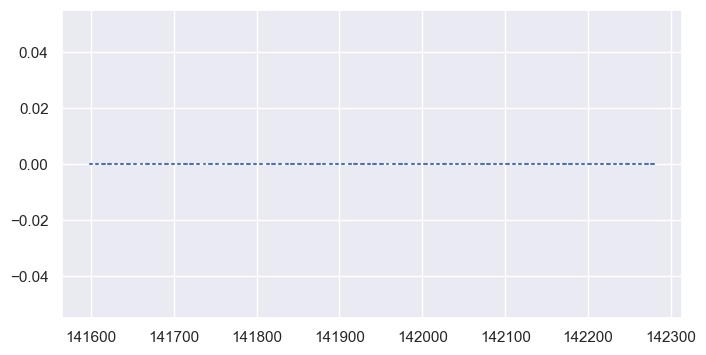

In [141]:
plt.plot(trx_df_test.loc[141595:]["preds"])

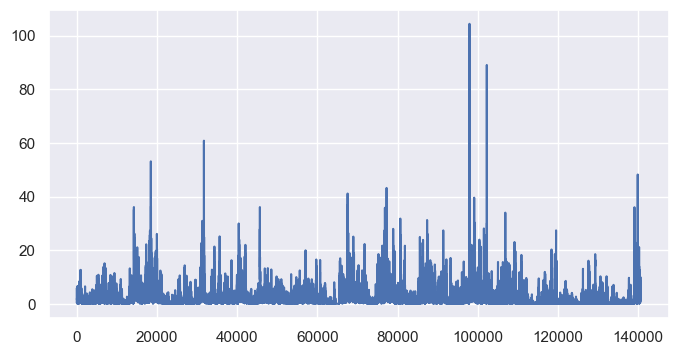

In [152]:
plt.plot(trx_df_train["preds"])

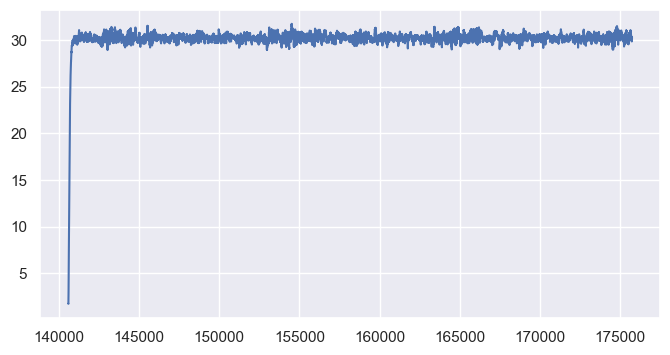

In [153]:
plt.plot(trx_df_test["predicted_volatility"])

In [123]:
trx_df_test.head()

,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,log_deseasonalized_preds,deseasonalized_preds,preds,predicted_volatility,resids_
140592,2018-09-06 12:13:05+00:00,0.010827,0.000000,1.0,0.0,0.010827,1.0,0.010827,8.069099,0.001342,-6.613651,-7.146490,0.000788,0.006355,1.752315,0.532839
140593,2018-09-06 12:14:05+00:00,1.139073,32.505673,3.0,4.0,31.366600,1.0,33.644746,6.600579,5.097242,1.628700,4.027397,56.114633,370.389065,1.736455,-2.398697
140594,2018-09-06 12:15:05+00:00,10.533393,0.516823,5.0,4.0,10.016569,1.0,11.050216,6.153717,1.795698,0.585394,-8.716775,0.000164,0.001008,1.756430,9.302169
140595,2018-09-06 12:16:05+00:00,0.039058,0.165731,1.0,2.0,0.126672,1.0,0.204789,6.763277,0.030280,-3.497279,0.405574,1.500163,10.146021,2.231848,-3.902853
140596,2018-09-06 12:17:05+00:00,0.100000,0.153261,1.0,3.0,0.053261,2.0,0.253261,6.367618,0.039773,-3.224557,-6.091036,0.002263,0.014410,2.284450,2.866479


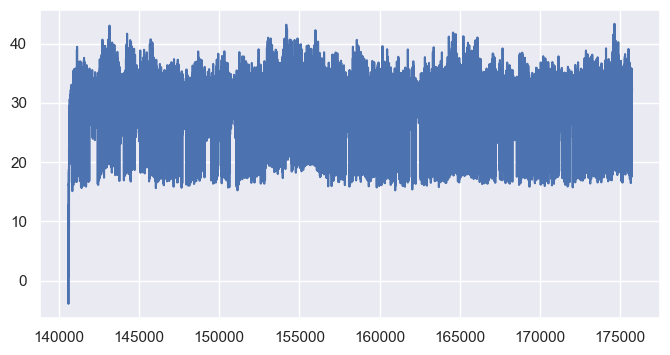

In [154]:
plt.plot(trx_df_test["resids_"])

In [155]:
y_test, y_test_pred = trx_df_test.loc[train_size:, "total_volume"].values, trx_df_test.loc[train_size:, "preds"].values

In [156]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have y_test and y_test_pred as arrays or Series

# MAE
mae = mean_absolute_error(y_test, y_test_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 3.6378
RMSE: 12.0117


In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have y_test and y_test_pred as arrays or Series

# MAE
mae = mean_absolute_error(y_test, y_test_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 3.6417
RMSE: 12.1373


In [28]:
garch_result.conditional_volatility

0         2.177256
1         2.185856
2         2.212433
3         2.240571
4         2.231571
            ...   
140587    1.787965
140588    1.785091
140589    1.790002
140590    1.774828
140591    1.760463
Name: cond_vol, Length: 140592, dtype: float64